In [1]:
!pip install xgboost
!pip install imblearn
!pip install pycaret

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from IPython.display import display
import math
from scipy.stats import chi2_contingency
# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#classification aglorithms
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate

from imblearn.over_sampling import SMOTE

#evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc)
from sklearn.metrics import make_scorer


In [3]:
df=pd.read_csv('term-deposit-marketing-2020.csv')
df_copy=df.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
print("Shape of the data:", df.shape)
df.info()

Shape of the data: (40000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [5]:
categorical_variables=df.select_dtypes(include=['object']).columns
numerical_variables=df.select_dtypes(include=['int64','float64']).columns
# Summary statistics for numerical variables
print('Numerical Statistics:')
display(df.describe())
print('Categorical Columns Counts:')
# Frequency count for categorical variables
for column in df.select_dtypes(include=['object']).columns:
    display(pd.DataFrame(df[column].value_counts()))

Numerical Statistics:


,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


Categorical Columns Counts:


,job
blue-collar,9383
management,8166
technician,6852
admin,4483
services,3910
retired,1437
self-employed,1414
entrepreneur,1405
unemployed,1104
housemaid,1087


,marital
married,24386
single,10889
divorced,4725


,education
secondary,20993
tertiary,11206
primary,6270
unknown,1531


,default
no,39191
yes,809


,housing
yes,24031
no,15969


,loan
no,33070
yes,6930


,contact
cellular,24914
unknown,12765
telephone,2321


,month
may,13532
jul,6380
aug,5215
jun,4734
nov,3598
apr,2718
feb,2296
jan,1176
mar,258
oct,80


,y
no,37104
yes,2896


In [6]:
#helper functions
sns.set_theme(rc={'figure.figsize':(10, 10)})
def plot_numerical_hist(column_name):
    df[column_name].hist(bins=30, edgecolor='black')
    if column_name in ['balance', 'duration', 'campaign']:
        plt.yscale('log')
    plt.title(f'{column_name.capitalize()} Distribution')
    plt.xlabel(column_name.capitalize())
    plt.ylabel('Frequency')
    plt.show()
def box_or_violin_plots(column_name, dataframe=df, target_col='y', plot_type='boxplot'):
    # box plot or violin plot of numerical variable vs target variable
    if plot_type == 'boxplot':
        sns.boxplot(x=target_col, y=column_name, data=dataframe)
    elif plot_type == 'violinplot':
        sns.violinplot(x=target_col, y=column_name, data=dataframe)
    plt.title(f'{column_name.capitalize()} by {target_col.capitalize()}')
    plt.ylabel(column_name.capitalize())
    plt.xlabel(target_col.capitalize())
    plt.legend(loc='upper left')
    plt.xticks(rotation=30)
    plt.show()
def plot_categorical_hist(column_name, dataframe=df, y='y'):
    df_plot = df.groupby([column_name, y]).size().reset_index().pivot(columns=column_name, index=y, values=0)
    df_plot.plot(kind='bar', stacked=True)
    plt.title(column_name.title(), fontsize = 15)
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.xticks(rotation=30)
    plt.show()
def plot_yes_counts_and_proportions(df, category_columns):
    n = len(category_columns)
    n_cols = 2
    n_rows = math.ceil(n * 2 / n_cols)  # 2 rows per category: one for count and one for proportion
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    if n_rows == 1:
        axes = [axes]
    
    for i, category_column in enumerate(category_columns):
        # Plot counts
        row = i*2 // n_cols
        col = (i*2) % n_cols
        ax = axes[row][col]
        
        sns.countplot(data=df, x=category_column, hue='y', ax=ax)
        ax.set_title(f'Count of responses by {category_column.capitalize()}')
        # Plot proportions
        row = (i*2 + 1) // n_cols
        col = (i*2 + 1) % n_cols
        ax = axes[row][col]
        
        proportion = df[df['y'] == 'yes'][category_column].value_counts() / df[category_column].value_counts()
        proportion.sort_index().plot(kind='bar', ax=ax)
        
        ax.set_ylabel('Proportion of Yes responses')
        ax.set_title(f'Proportion of Yes responses by {category_column.capitalize()}')
        
    plt.tight_layout()
    plt.show()
    
def eval_results(actual, predictions):
    print('_____________________________________\n')
    print('Model Evaluation on Test Set:')
    # F1 Score
    print("F1 Score: ", f1_score(actual, predictions))
    
    # Accuracy
    print("Accuracy: ", accuracy_score(actual, predictions))
    
    # Precision
    print("Precision: ", precision_score(actual, predictions, pos_label=1))
    
    # Recall
    print("Recall: ", recall_score(actual, predictions, pos_label=1))
    
    # Visualize the evaluation report
    print("\nClassification Report:\n")
    print(classification_report(actual, predictions))
    
    # Plot the advanced confusion matrix
    cm = confusion_matrix(actual, predictions)
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    categories = ['Not_Subscribed', 'Subscribed']
    cm_plot = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues_r', xticklabels=categories, yticklabels=categories)
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')
    cm_plot.set_title('Confusion Matrix')
    plt.show()
    
    # Total predictions for each class
    print("Total predictions for class 0: ", np.bincount(predictions)[0])
    print("Total predictions for class 1: ", np.bincount(predictions)[1])

def plot_individual_roc_curve(name, fpr, tpr, add_legend=False):
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    if add_legend:
        plt.legend(loc="lower right")

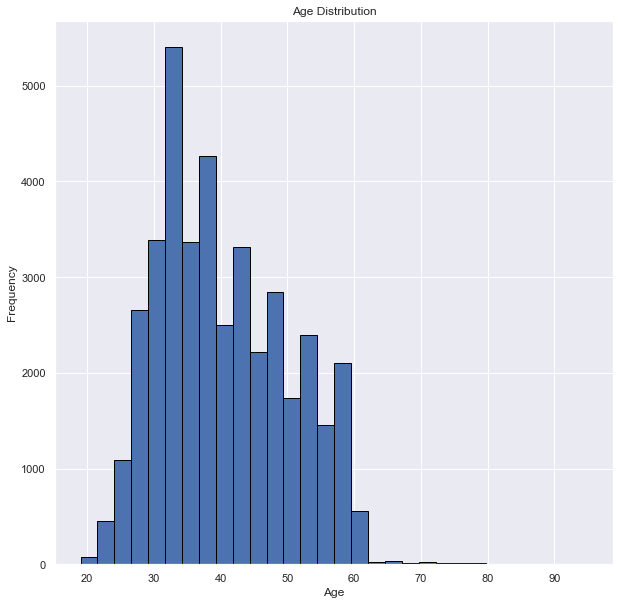

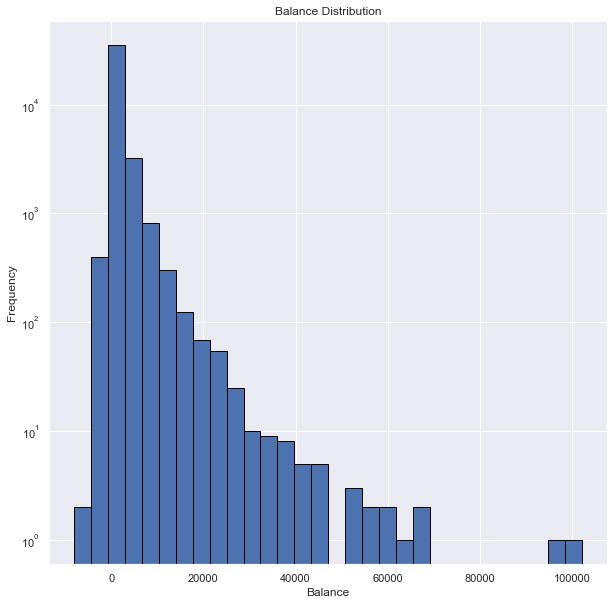

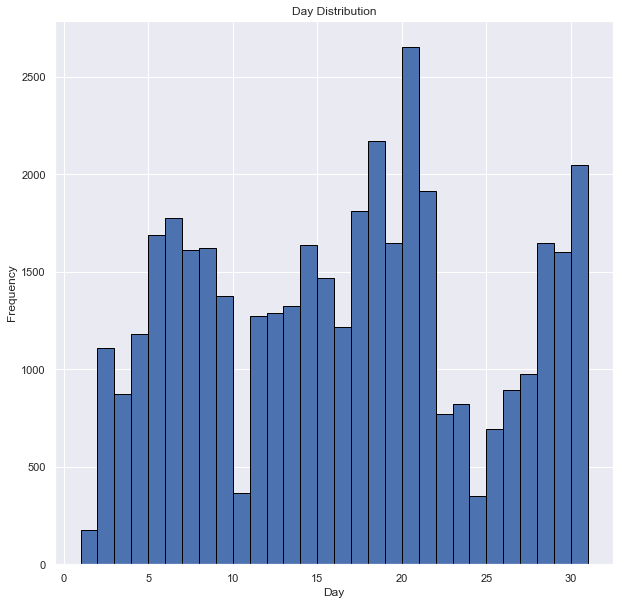

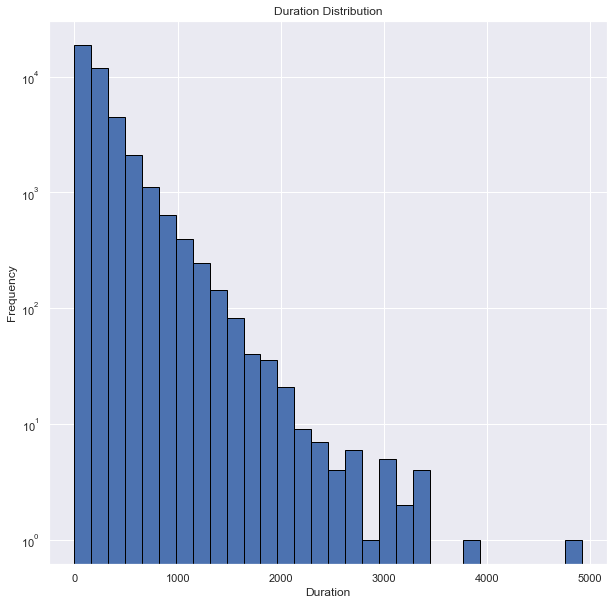

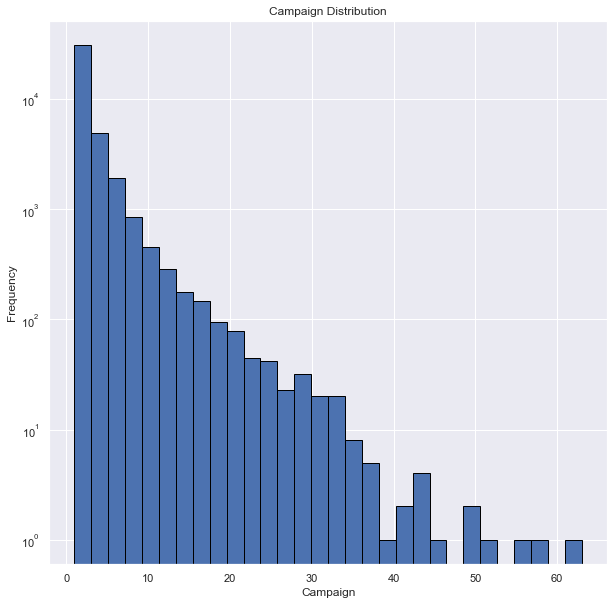

In [33]:
for column in numerical_variables:
    plot_numerical_hist(column)

Correlation Matrix for Numerical Variables


,age,balance,day,duration,campaign
age,1.000000,0.081517,-0.011689,-0.036270,0.016204
balance,0.081517,1.000000,0.011662,0.014072,-0.008137
day,-0.011689,0.011662,1.000000,-0.032983,0.165429
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000


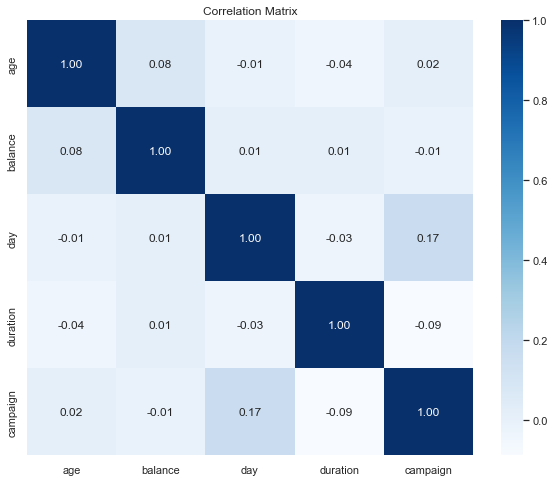

Pair Plots for Some Numerical Variable Relationships


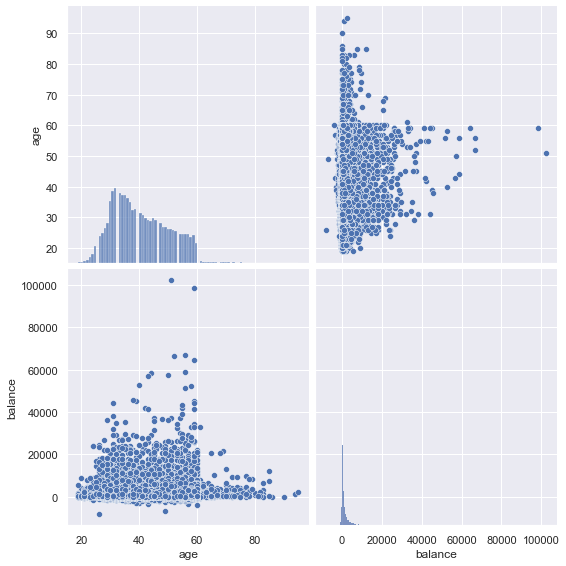

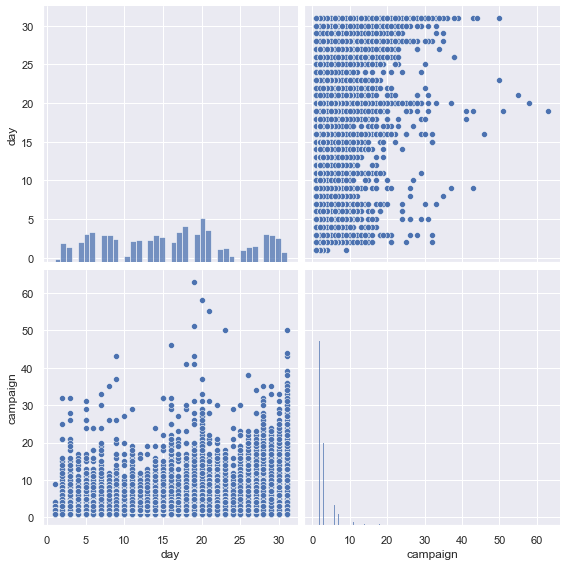

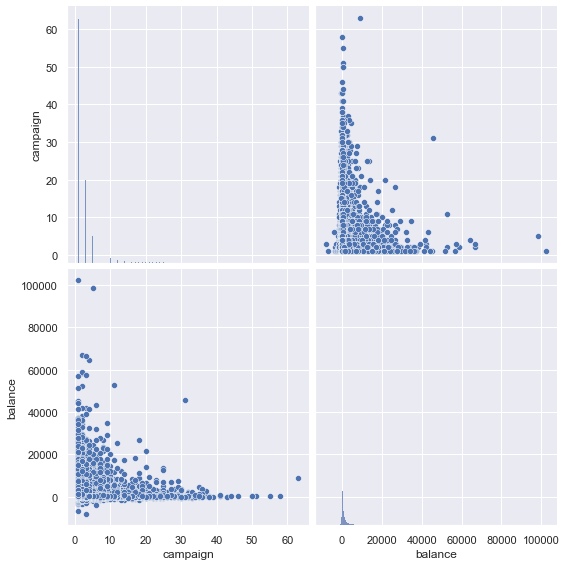

In [34]:
print ('Correlation Matrix for Numerical Variables')
corr = df.corr()
display(corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

print('Pair Plots for Some Numerical Variable Relationships')
# Pair plot for age and balance
sns.pairplot(df[['age', 'balance']],height=4)
# Pair plot for day and campaign
sns.pairplot(df[['day', 'campaign']],height=4)
#pair plot for campaign and balance
sns.pairplot(df[['campaign', 'balance']],height=4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


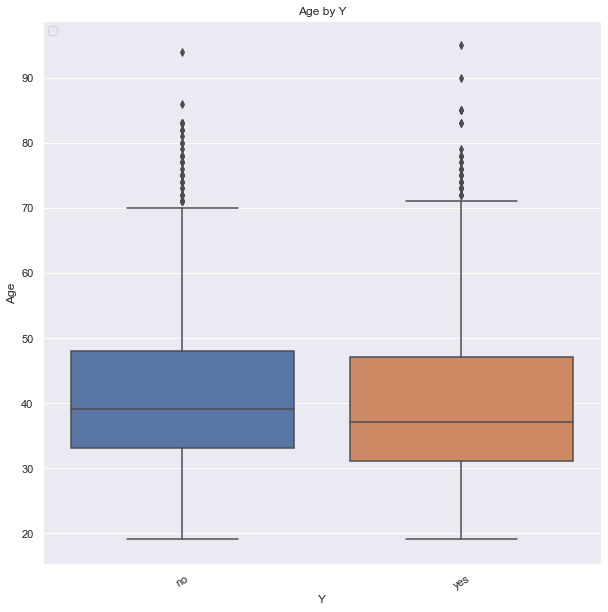

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


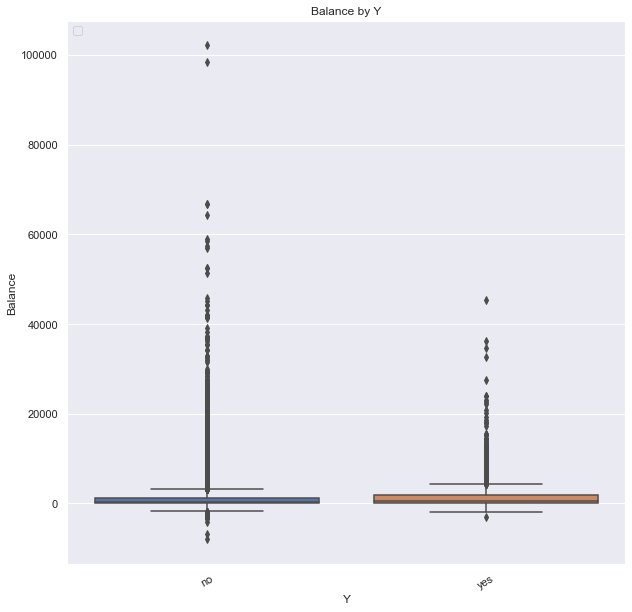

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


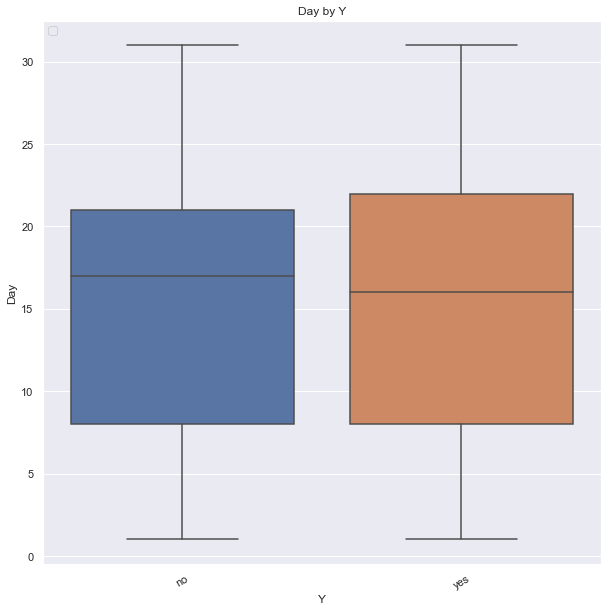

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


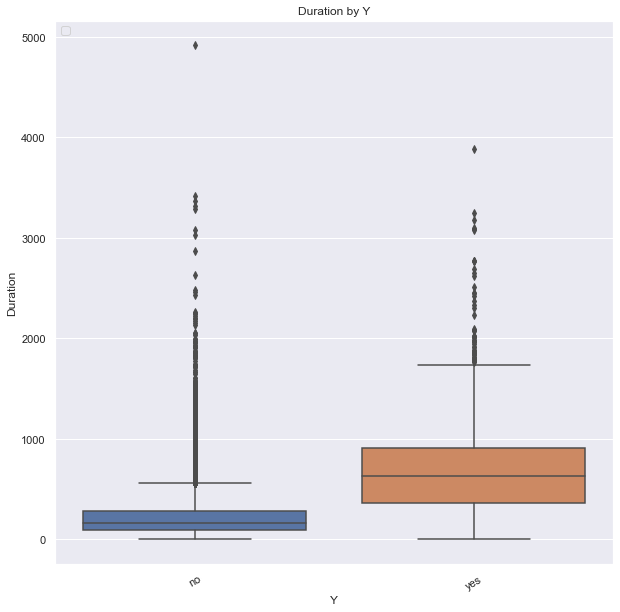

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


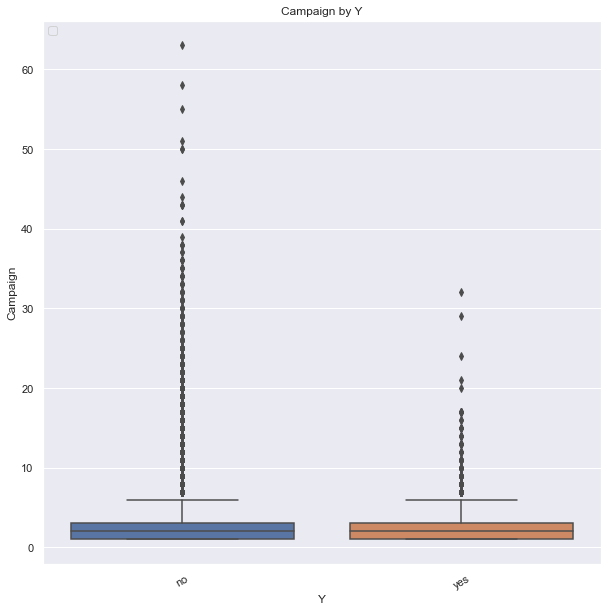

In [35]:
#box plot of numerical variable vs target variable

for column in numerical_variables:
    box_or_violin_plots(column)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


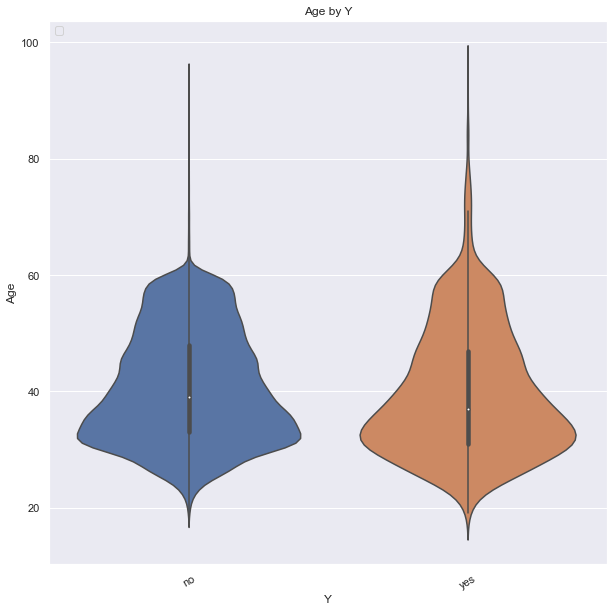

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


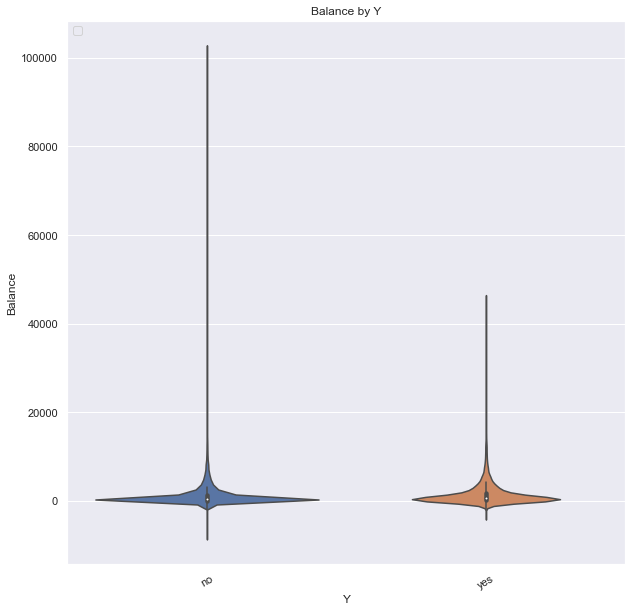

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


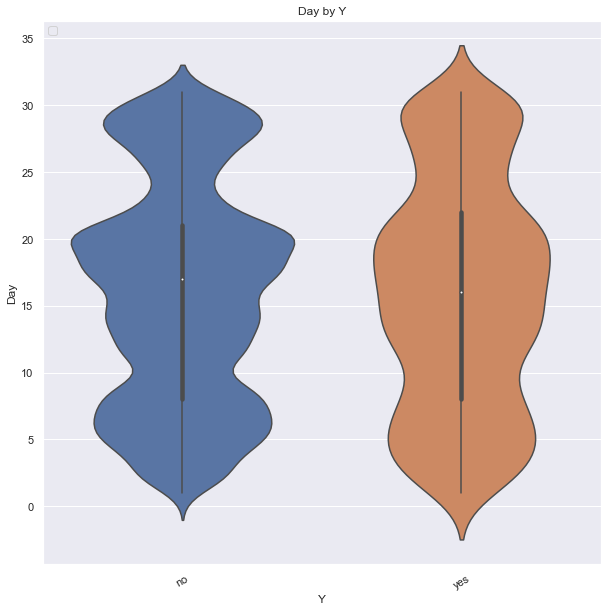

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


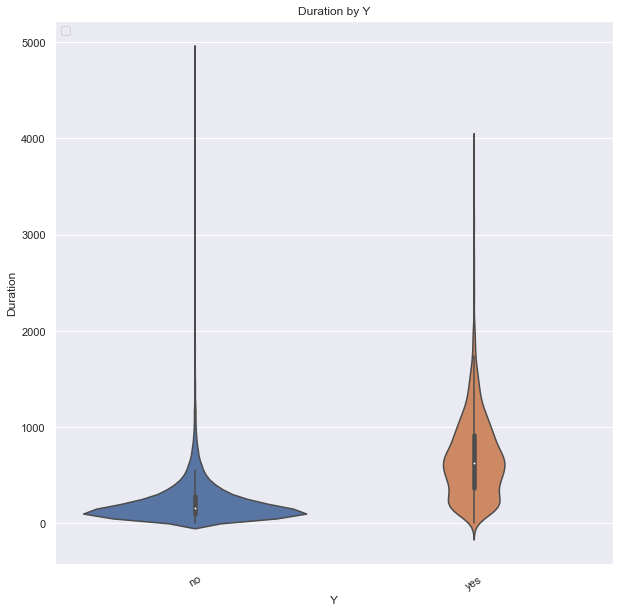

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


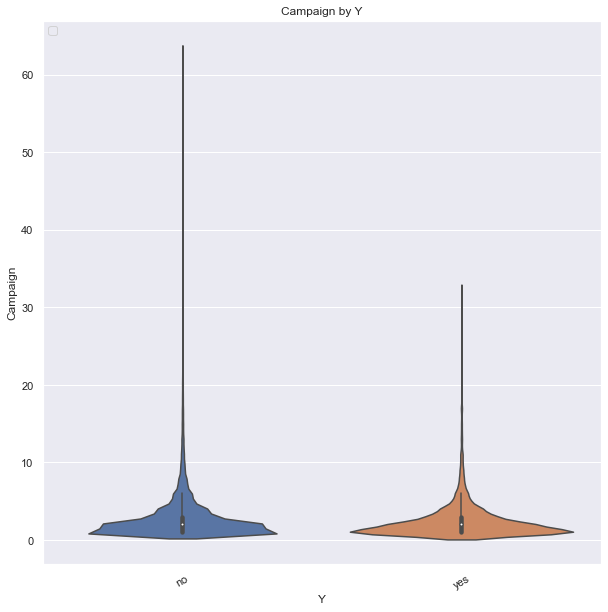

In [36]:
#violin plot of numerical variable vs target variable

for column in numerical_variables:
    box_or_violin_plots(column, plot_type='violinplot')

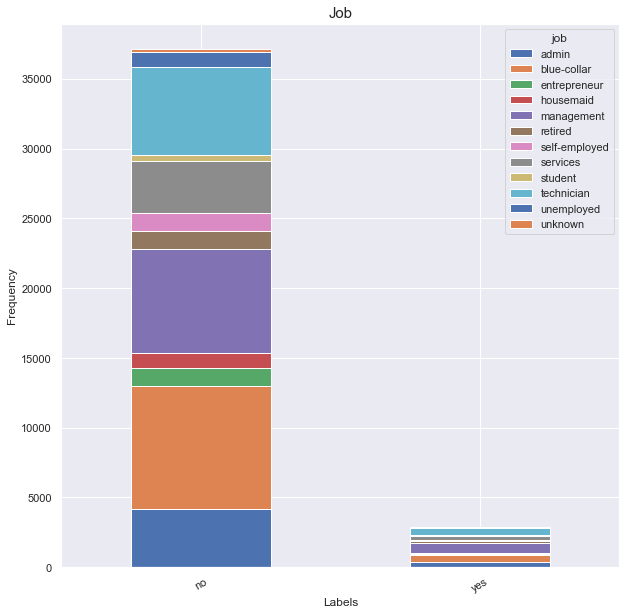

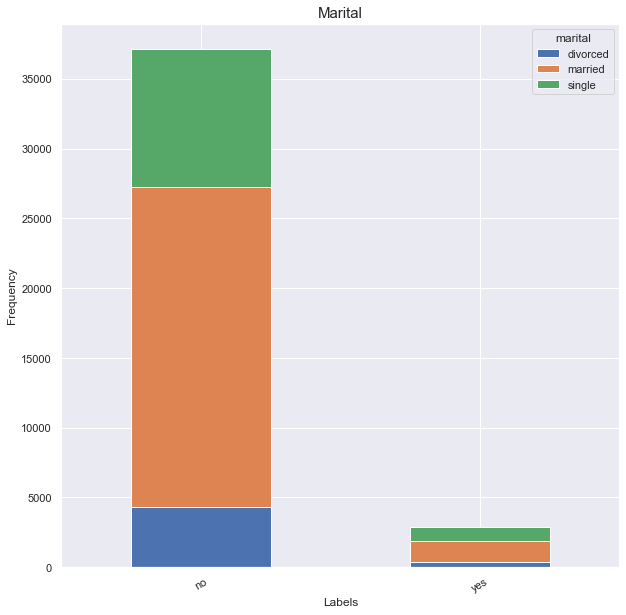

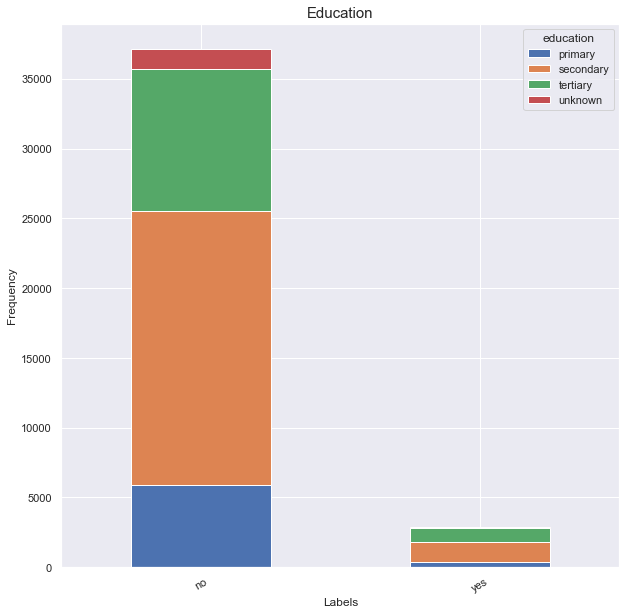

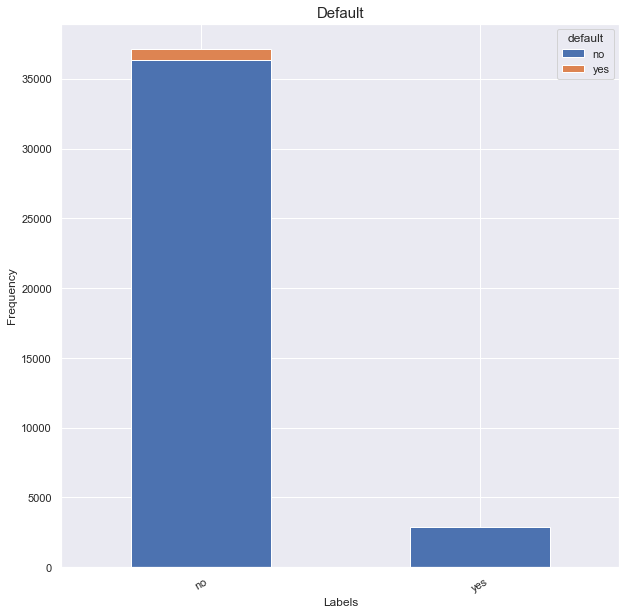

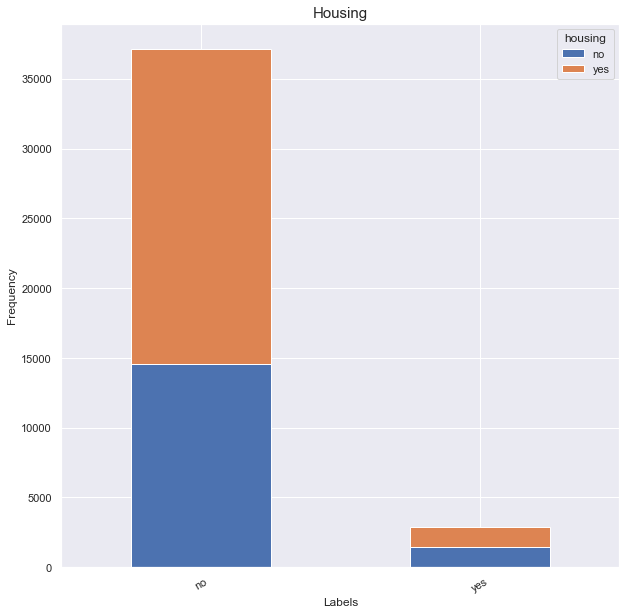

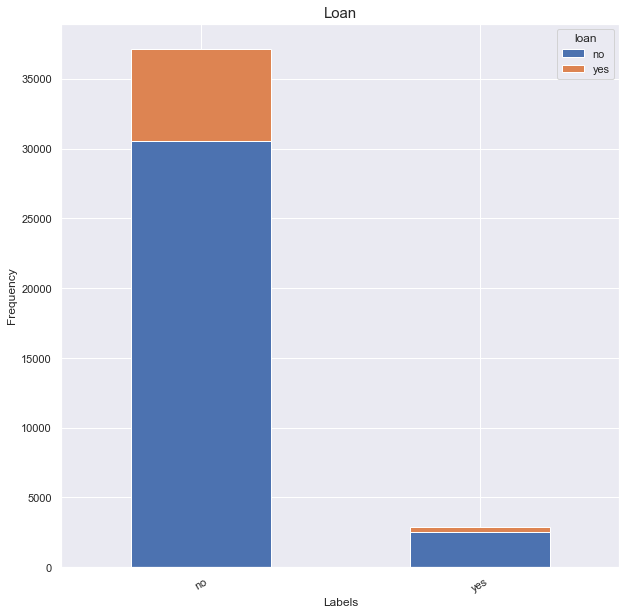

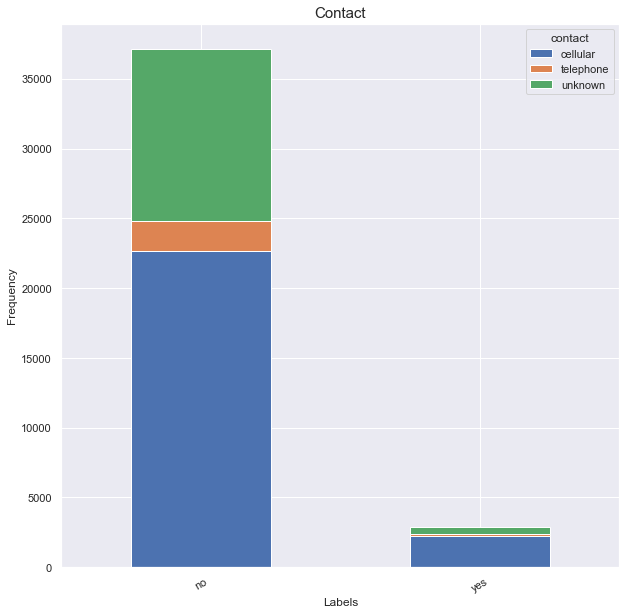

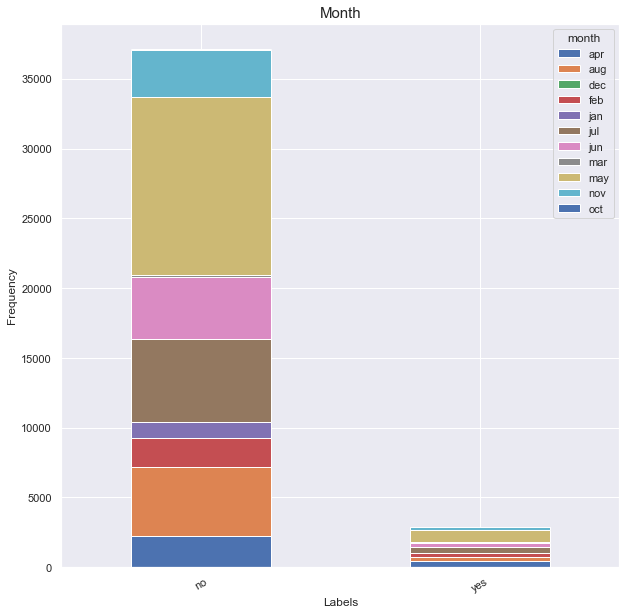

In [37]:
for column in categorical_variables:
    if column!= 'y':
        plot_categorical_hist(column)

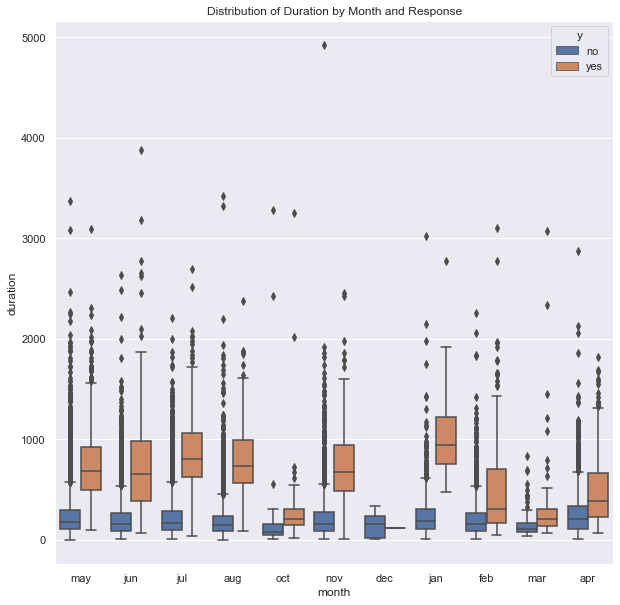

In [38]:
sns.boxplot(x='month', y='duration', hue='y', data=df)
plt.title('Distribution of Duration by Month and Response')
plt.show()

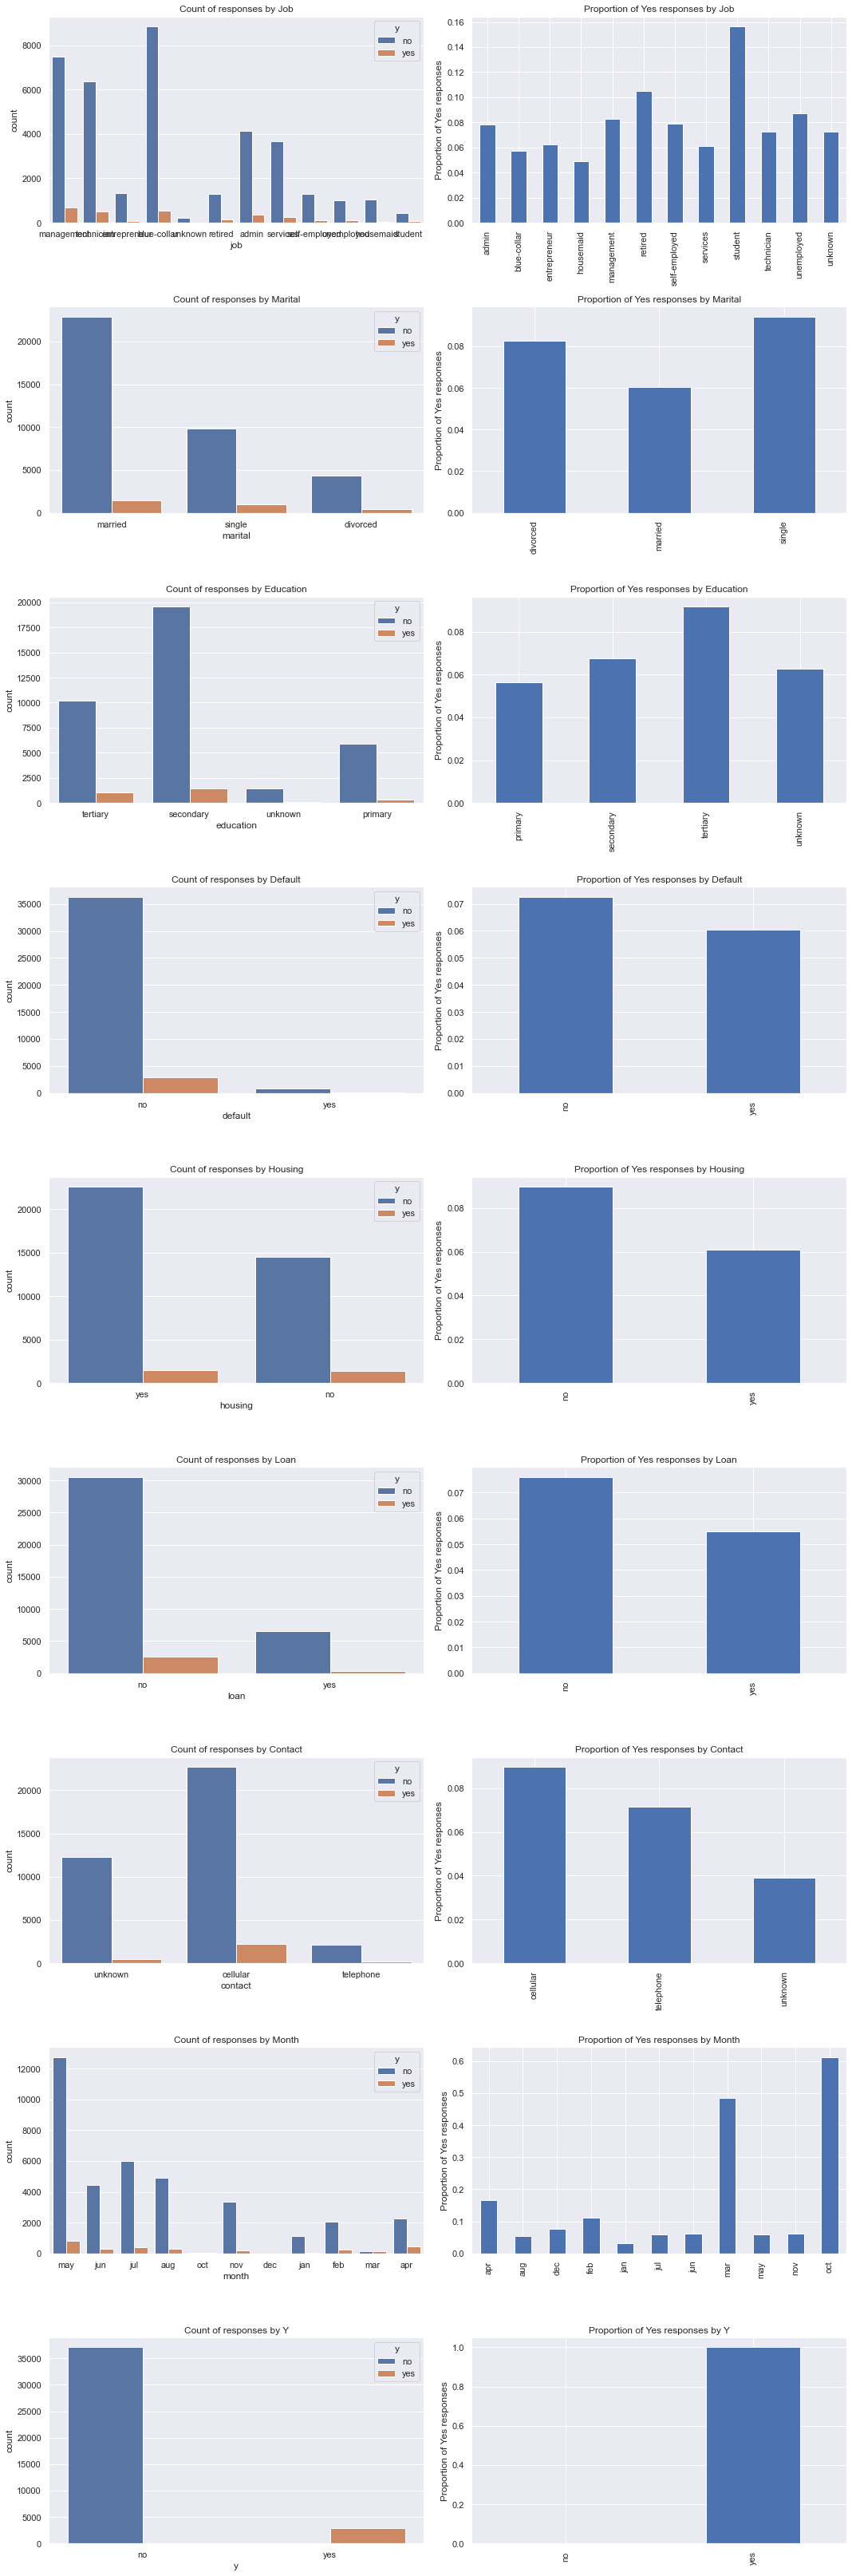

In [39]:
plot_yes_counts_and_proportions(df_copy, categorical_variables)

In [40]:
for column in categorical_variables:
    if column != 'y':  # we don't want to perform a chi-square test of 'y' with itself
        contingency = pd.crosstab(df[column], df['y'])
        display(contingency)  # Displays the contingency table
        chi2, p, dof, expected = chi2_contingency(contingency)
        print(f'Chi-square test for variable: {column}')
        print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')

y,no,yes
job,,
admin,4132,351
blue-collar,8848,535
entrepreneur,1317,88
housemaid,1034,53
management,7490,676
retired,1286,151
self-employed,1302,112
services,3672,238
student,442,82


Chi-square test for variable: job
Chi-square statistic: 149.75042154316787
P-value: 1.6761348063575326e-26
Degrees of freedom: 11



y,no,yes
marital,,
divorced,4334,391
married,22908,1478
single,9862,1027


Chi-square test for variable: marital
Chi-square statistic: 135.89809645322464
P-value: 3.091030601234065e-30
Degrees of freedom: 2



y,no,yes
education,,
primary,5917,353
secondary,19575,1418
tertiary,10177,1029
unknown,1435,96


Chi-square test for variable: education
Chi-square statistic: 96.67441494404031
P-value: 8.061910845440867e-21
Degrees of freedom: 3



y,no,yes
default,,
no,36344,2847
yes,760,49


Chi-square test for variable: default
Chi-square statistic: 1.54594344848905
P-value: 0.21373529827845061
Degrees of freedom: 1



y,no,yes
housing,,
no,14537,1432
yes,22567,1464


Chi-square test for variable: housing
Chi-square statistic: 117.66942117763818
P-value: 2.048342664339848e-27
Degrees of freedom: 1



y,no,yes
loan,,
no,30554,2516
yes,6550,380


Chi-square test for variable: loan
Chi-square statistic: 38.19687165861611
P-value: 6.395487199647575e-10
Degrees of freedom: 1



y,no,yes
contact,,
cellular,22681,2233
telephone,2155,166
unknown,12268,497


Chi-square test for variable: contact
Chi-square statistic: 323.00727546041765
P-value: 7.242046790893985e-71
Degrees of freedom: 2



y,no,yes
month,,
apr,2267,451
aug,4927,288
dec,12,1
feb,2041,255
jan,1138,38
jul,5996,384
jun,4440,294
mar,133,125
may,12741,791


Chi-square test for variable: month
Chi-square statistic: 1523.7066616727582
P-value: 0.0
Degrees of freedom: 10



Now lets encode our categorical variables. The obvious binary Y/N answers will be manually encoded to be 1 or 0. The month will be 1-12. The rest we'll start with one-hot encoding and eventually do oneshot enconding. 

In [7]:
columns_to_check = ['month', 'default', 'housing', 'loan', 'y']

for column in columns_to_check:
    print(f"Unique values in {column}: {df[column].unique()}")
# Define our replacement dictionaries
month_replace = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

binary_replace = {
    'yes': 1,
    'no': 0
}

# Perform the replacements
df['month'] = df['month'].replace(month_replace)
df['default'] = df['default'].replace(binary_replace)
df['housing'] = df['housing'].replace(binary_replace)
df['loan'] = df['loan'].replace(binary_replace)
df['y'] = df['y'].replace(binary_replace)

# Display the head to see the changes
df.head()

# the remaining categorical columns are 'job', 'marital', 'education', 'contact'
categorical_columns_to_encode = ['job', 'marital', 'education', 'contact']

# Create dummy variables
for column in categorical_columns_to_encode:
    df = pd.get_dummies(df, columns=[column], dtype='int16') 

#cylical encoding for days within month
def day_transformation(column):
    max_value = column.max()
    sin_values = [np.sin((2*np.pi*x)/max_value) for x in list(column)]
    cos_values = [np.cos((2*np.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

df["day_sin"], df["day_cos"] = day_transformation(df["day"])

df.head()

Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
Unique values in default: ['no' 'yes']
Unique values in housing: ['yes' 'no']
Unique values in loan: ['no' 'yes']
Unique values in y: ['no' 'yes']


,age,default,balance,housing,loan,day,month,duration,campaign,y,...,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,day_sin,day_cos
0,58,0,2143,1,0,5,5,261,1,0,...,0,0,0,1,0,0,0,1,0.848644,0.528964
1,44,0,29,1,0,5,5,151,1,0,...,1,0,1,0,0,0,0,1,0.848644,0.528964
2,33,0,2,1,1,5,5,76,1,0,...,0,0,1,0,0,0,0,1,0.848644,0.528964
3,47,0,1506,1,0,5,5,92,1,0,...,0,0,0,0,1,0,0,1,0.848644,0.528964
4,33,0,1,0,0,5,5,198,1,0,...,1,0,0,0,1,0,0,1,0.848644,0.528964


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  40000 non-null  int64  
 1   default              40000 non-null  int64  
 2   balance              40000 non-null  int64  
 3   housing              40000 non-null  int64  
 4   loan                 40000 non-null  int64  
 5   day                  40000 non-null  int64  
 6   month                40000 non-null  int64  
 7   duration             40000 non-null  int64  
 8   campaign             40000 non-null  int64  
 9   y                    40000 non-null  int64  
 10  job_admin            40000 non-null  int16  
 11  job_blue-collar      40000 non-null  int16  
 12  job_entrepreneur     40000 non-null  int16  
 13  job_housemaid        40000 non-null  int16  
 14  job_management       40000 non-null  int16  
 15  job_retired          40000 non-null 

Lets proceed with training our model by importing libraries and splitting the datset

0    37104
1     2896
Name: y, dtype: int64


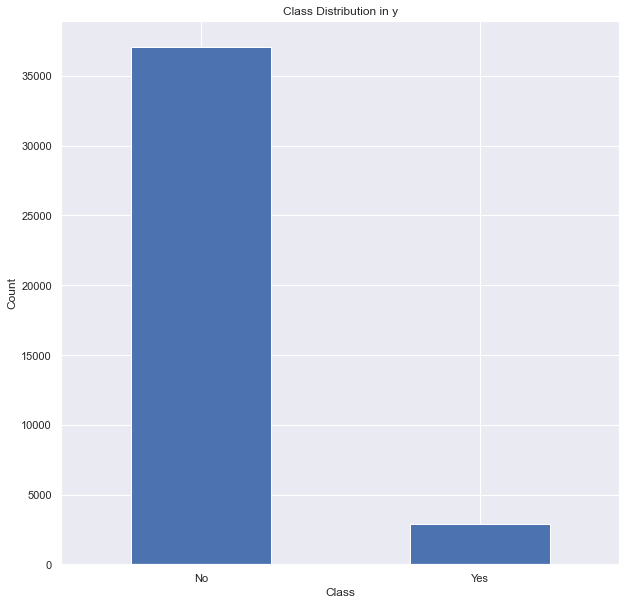

In [43]:
# Count the occurrences of each class in 'y'
class_counts = df['y'].value_counts()
print(class_counts)
# Create a bar chart for the classes
class_counts.plot(kind='bar')

# Add titles and labels
plt.title('Class Distribution in y')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
# Show the plot
plt.show()


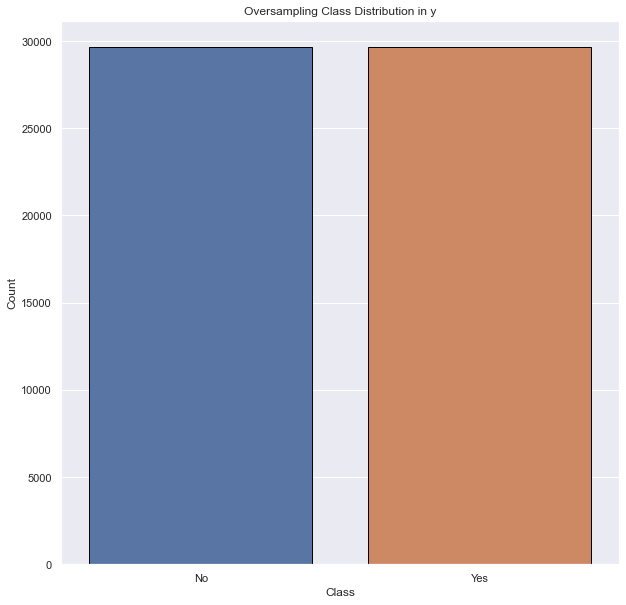

Training data distribution
 0    29683
1    29683
Name: y, dtype: int64
Training data Shape:  (59366, 33)
Test data distribution
 0    7421
1     579
Name: y, dtype: int64
Test data Shape:  (8000, 33)


In [8]:
# Define your features and target variable
data = df.drop('y', axis=1)  # Features (all columns except 'y')
target = df['y']  # Target variable

# Split the data into training and testing sets stratified to keep same ratio
X_train_pre, X_test_pre, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)

# Normalization of variables from 0 to 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_pre)
X_test = scaler.transform(X_test_pre)

# Implement oversampling using SMOTE for imbalance
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

# Plotting
sns.countplot(x='y', data=y_train_smote.to_frame(), edgecolor='black')

# Add titles and labels
plt.title('Oversampling Class Distribution in y')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
# Show the plot
plt.show()

# Print class distribution
print("Training data distribution\n", y_train_smote.value_counts())
print("Training data Shape: ", X_train_smote.shape)
print("Test data distribution\n", y_test.value_counts())
print("Test data Shape: ", X_test.shape)


## 1. Random Forest Model

In [9]:
# Define custom scorers and scoring dictionary
custom_precision = make_scorer(precision_score, pos_label=1)
custom_recall = make_scorer(recall_score, pos_label=1)
custom_f1 = make_scorer(f1_score, pos_label=1)

scoring = {'accuracy': 'accuracy', 'precision': custom_precision, 'recall': custom_recall, 'f1': custom_f1}

In [45]:
param_rf={'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9, 30],
            'max_features' : ['log2', 'sqrt'], 'criterion':['gini', 'entropy']
            }

random_forest=RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(random_forest, param_rf, cv=5)
grid_search_rf_fit=grid_search_rf.fit(X_train_smote, y_train_smote)
print(grid_search_rf_fit.best_params_)

{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'n_estimators': 200}


AUC:  0.9427745423934644
Mean Accuracy: 0.9668165815460835
Mean Precision: 0.9567115660970493
Mean Recall: 0.9782044066017533
Mean F1: 0.966760862157026
_____________________________________

Model Evaluation on Test Set:
F1 Score:  0.5273972602739726
Accuracy:  0.931
Precision:  0.5229202037351444
Recall:  0.531951640759931

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7421
           1       0.52      0.53      0.53       579

    accuracy                           0.93      8000
   macro avg       0.74      0.75      0.75      8000
weighted avg       0.93      0.93      0.93      8000



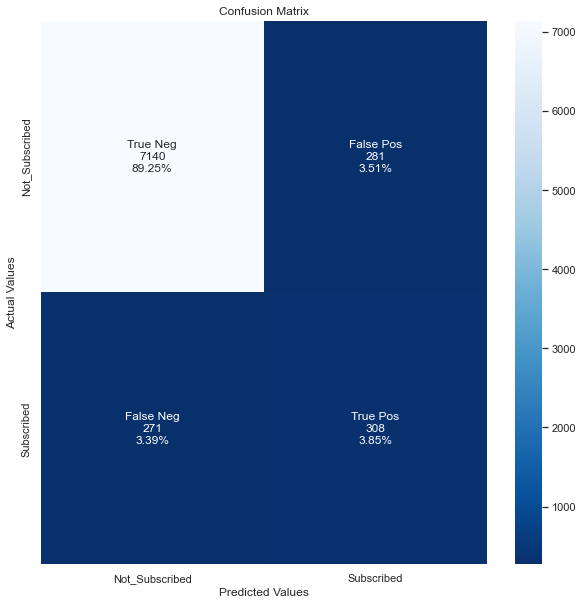

Total predictions for class 0:  7411
Total predictions for class 1:  589


In [27]:
# Fit the RandomForestClassifier using the best hyperparameters
rfc = RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=200, max_features='log2', random_state=42)
rfc.fit(X_train_smote, y_train_smote)

# Make predictions and compute AUC
rfc_y_predicted = rfc.predict(X_test)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])  # This line calculates the ROC curve
print("AUC: ", roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))

# Perform 5-fold cross-validation on training dataset and get the mean scores for the training dataset
cv_results = cross_validate(rfc, X=X_train_smote, y=y_train_smote, scoring=scoring, cv=5, n_jobs=-1, verbose=0)
mean_accuracy = np.mean(cv_results['test_accuracy'])
mean_precision = np.mean(cv_results['test_precision'])
mean_recall = np.mean(cv_results['test_recall'])
mean_f1 = np.mean(cv_results['test_f1'])

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1: {mean_f1}")

# Finally evaluate the model on the test set
eval_results(y_test, rfc_y_predicted)

## Results
We can see above that the model has a high accuracy score and fits well to the test set, this is due to the imbalanced dataset allowing the model to more readily predict true negatives. However, its recall and precision scores are low, and it misclassifies over 500 examples. 

## Comapre other models after hyper-parameter fine tuning with gridsearchCV (5 folds)

In [15]:
#Define models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(),
    "Neural Network": MLPClassifier(),
    'Logistic Regression': LogisticRegression()
}
# Define hyperparameter grids
param_grids = {
    "Decision Tree": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'max_depth': [5, 7, 10],
    },
    "Neural Network": {
        'hidden_layer_sizes': [(5,2)],  # Fewer neurons
        'activation': ['relu'],  # Generally faster
        'alpha': [0.01],  # Regularization can sometimes speed up convergence
        'learning_rate_init': [0.01],  # Larger learning rate
    },
    'Logistic Regression': {
            'C': [1,5,10],
            'max_iter' : [100, 1000, 2000]
        }
}

In [16]:
scores = []

# Loop through rest of potential models above and perform hyperparameter tuning
for model_name, model in models.items():
    clf = GridSearchCV(model, param_grids[model_name], cv=5, scoring=custom_f1, return_train_score=False)
    clf.fit(X_train_smote, y_train_smote)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [20]:
df_grid_search = pd.DataFrame(scores,columns=['model','best_score','best_params'])
neural_net_params = df_grid_search[df_grid_search['model'] == 'Neural Network']['best_params'].values[0]
decision_tree_params = df_grid_search[df_grid_search['model'] == 'Decision Tree']['best_params'].values[0]
xgboost_params = df_grid_search[df_grid_search['model'] == 'XGBoost']['best_params'].values[0]
display(df_grid_search)
print("Neural Network Params:", neural_net_params)
print("Decision Tree Params:", decision_tree_params)
print("XGBoost Params:", xgboost_params)

,model,best_score,best_params
0,Decision Tree,0.938964,"{'criterion': 'entropy', 'max_depth': 20, 'min..."
1,XGBoost,0.948419,{'max_depth': 10}
2,Neural Network,0.905696,"{'activation': 'relu', 'alpha': 0.01, 'hidden_..."
3,Logistic Regression,0.848349,"{'C': 1, 'max_iter': 100}"


Neural Network Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (5, 2), 'learning_rate_init': 0.01}
Decision Tree Params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
XGBoost Params: {'max_depth': 10}


## 2. XGBoost

AUC:  0.9484746526393498
Mean Accuracy: 0.9520954936573203
Mean Precision: 0.9661834168600094
Mean Recall: 0.9381838935961468
Mean F1: 0.9476477359465981
_____________________________________

Model Evaluation on Test Set:
F1 Score:  0.5333333333333333
Accuracy:  0.936125
Precision:  0.5658914728682171
Recall:  0.5043177892918825

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7421
           1       0.57      0.50      0.53       579

    accuracy                           0.94      8000
   macro avg       0.76      0.74      0.75      8000
weighted avg       0.93      0.94      0.93      8000



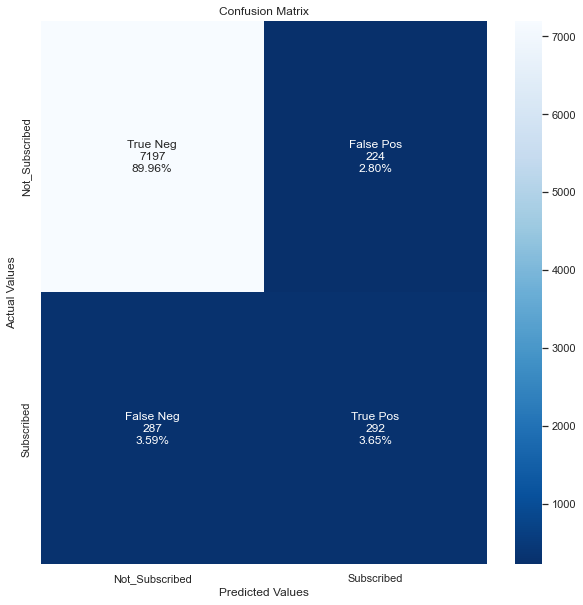

Total predictions for class 0:  7484
Total predictions for class 1:  516


In [21]:
xgb_model = XGBClassifier(objective='binary:logistic',min_child_weight=10, subsample=0.35, colsample_bytree=0.35, max_depth=10, learning_rate=0.01, n_estimators=1000, verbosity=0, njobs=-1)
xgb_model.fit(X_train_smote, y_train_smote)

# Make predictions and compute AUC
xgb_y_predicted = xgb_model.predict(X_test)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])  # This line calculates the ROC curve for XGB
print("AUC: ", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

# Perform 5-fold cross-validation on training dataset and get the mean scores for the training dataset
cv_results_xgb = cross_validate(xgb_model, X=X_train_smote, y=y_train_smote, scoring=scoring, cv=5, n_jobs=-1, verbose=0)
mean_accuracy_xgb = np.mean(cv_results_xgb['test_accuracy'])
mean_precision_xgb = np.mean(cv_results_xgb['test_precision'])
mean_recall_xgb = np.mean(cv_results_xgb['test_recall'])
mean_f1_xgb = np.mean(cv_results_xgb['test_f1'])

print(f"Mean Accuracy: {mean_accuracy_xgb}")
print(f"Mean Precision: {mean_precision_xgb}")
print(f"Mean Recall: {mean_recall_xgb}")
print(f"Mean F1: {mean_f1_xgb}")

# Finally evaluate the model on the test set
eval_results(y_test, xgb_y_predicted)

# 3. Artificial Neural Network

AUC:  0.9385211039297295
Mean Accuracy: 0.867415771493605
Mean Precision: 0.8670200830664495
Mean Recall: 0.8681413773189923
Mean F1: 0.8673674623706589
_____________________________________

Model Evaluation on Test Set:
F1 Score:  0.5279017857142858
Accuracy:  0.89425
Precision:  0.38994229183841717
Recall:  0.8169257340241797

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7421
           1       0.39      0.82      0.53       579

    accuracy                           0.89      8000
   macro avg       0.69      0.86      0.73      8000
weighted avg       0.94      0.89      0.91      8000



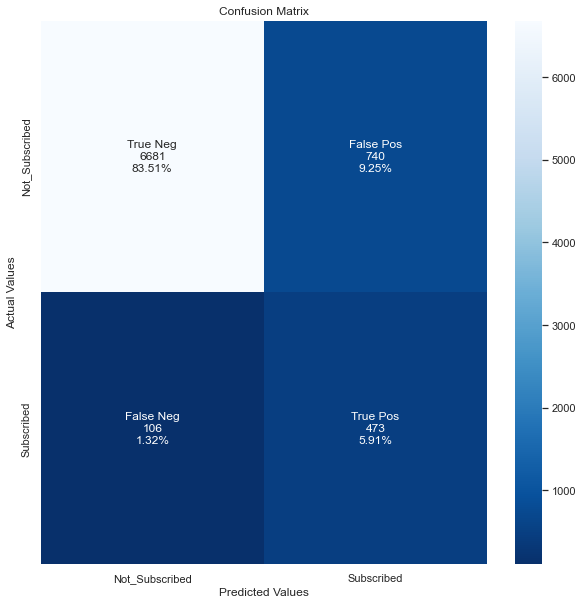

Total predictions for class 0:  6787
Total predictions for class 1:  1213


In [23]:
ann_model = MLPClassifier(activation = 'relu', alpha = 0.01, hidden_layer_sizes = (5, 2), learning_rate_init = 0.01, 
                      random_state=42)
ann_model.fit(X_train_smote, y_train_smote)
# Make predictions and compute AUC
ann_y_predicted = ann_model.predict(X_test)
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, ann_model.predict_proba(X_test)[:,1])  # This line calculates the ROC curve for XGB
print("AUC: ", roc_auc_score(y_test, ann_model.predict_proba(X_test)[:, 1]))

# Perform 5-fold cross-validation on training dataset and get the mean scores for the training dataset
cv_results_ann = cross_validate(ann_model, X=X_train_smote, y=y_train_smote, scoring=scoring, cv=5, n_jobs=-1, verbose=0)
mean_accuracy_ann = np.mean(cv_results_ann['test_accuracy'])
mean_precision_ann = np.mean(cv_results_ann['test_precision'])
mean_recall_ann = np.mean(cv_results_ann['test_recall'])
mean_f1_ann = np.mean(cv_results_ann['test_f1'])

print(f"Mean Accuracy: {mean_accuracy_ann}")
print(f"Mean Precision: {mean_precision_ann}")
print(f"Mean Recall: {mean_recall_ann}")
print(f"Mean F1: {mean_f1_ann}")

# Finally evaluate the model on the test set
eval_results(y_test, ann_y_predicted)

## 4. Decision Tree

AUC:  0.738448444513644
Mean Accuracy: 0.9405730268041846
Mean Precision: 0.9384487118041953
Mean Recall: 0.9434042338988853
Mean F1: 0.9394830977873095
_____________________________________

Model Evaluation on Test Set:
F1 Score:  0.4555382215288611
Accuracy:  0.91275
Precision:  0.41536273115220484
Recall:  0.5043177892918825

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7421
           1       0.42      0.50      0.46       579

    accuracy                           0.91      8000
   macro avg       0.69      0.72      0.70      8000
weighted avg       0.92      0.91      0.92      8000



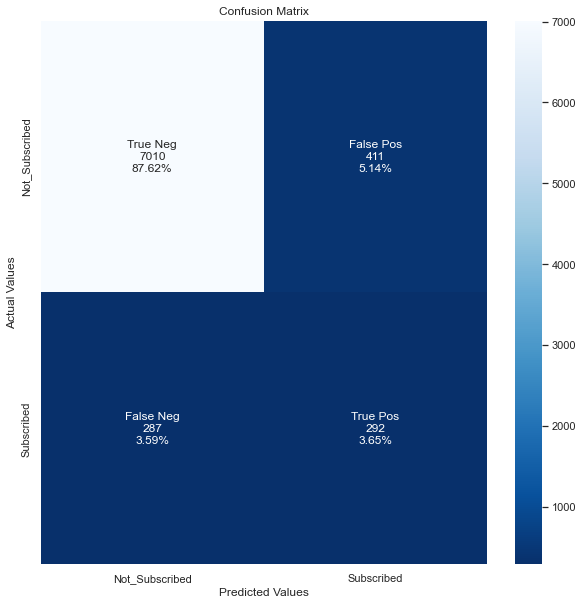

Total predictions for class 0:  7297
Total predictions for class 1:  703


In [25]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, random_state=42)
dt_model.fit(X_train_smote, y_train_smote)

# Make predictions and compute AUC
dt_y_predicted = dt_model.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_model.predict_proba(X_test)[:,1])  # This line calculates the ROC curve for XGB
print("AUC: ", roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1]))

# Perform 5-fold cross-validation on training dataset and get the mean scores for the training dataset
cv_results_dt = cross_validate(dt_model, X=X_train_smote, y=y_train_smote, scoring=scoring, cv=5, n_jobs=-1, verbose=0)
mean_accuracy_dt = np.mean(cv_results_dt['test_accuracy'])
mean_precision_dt = np.mean(cv_results_dt['test_precision'])
mean_recall_dt = np.mean(cv_results_dt['test_recall'])
mean_f1_dt = np.mean(cv_results_dt['test_f1'])

print(f"Mean Accuracy: {mean_accuracy_dt}")
print(f"Mean Precision: {mean_precision_dt}")
print(f"Mean Recall: {mean_recall_dt}")
print(f"Mean F1: {mean_f1_dt}")

# Finally evaluate the model on the test set
eval_results(y_test, dt_y_predicted)

In [43]:
# Initialize a dictionary to store results
results = {}

# Train, predict, and evaluate classifiers
for name, clf in classifiers.items():
    print(f"Training and tuning {name}...")
    
    # Perform Grid Search with 5-fold cross-validation
    grid_search = GridSearchCV(clf, param_grids[name], cv=5)
    grid_search.fit(X_train, y_train)
    
    # Use the best estimator found by GridSearchCV to make predictions
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    
    # Store metrics in the results dictionary
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "F1": f1_score(y_test, y_pred, pos_label=1)
    }
    
    # Display the best parameters and the classification report
    print(f"\nBest Parameters for {name}: {grid_search.best_params_}\n")
    print(f"{name} Classification Report:\n")
    display(classification_report(y_test, y_pred))
    print("----------------------------------------------------------\n")

# Convert the results dictionary into a DataFrame and display it
results_df = pd.DataFrame(results).transpose()
display(results_df)

Training and tuning Decision Tree...

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      9283
           1       0.56      0.39      0.46       717

    accuracy                           0.93     10000
   macro avg       0.76      0.68      0.71     10000
weighted avg       0.93      0.93      0.93     10000

----------------------------------------------------------

Training and tuning Random Forest...

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      9283
           1       0.59      0.29      0.39       717

    accuracy                           0.93     1

,Accuracy,Precision,Recall,F1
Decision Tree,0.9346,0.563126,0.391911,0.462171
Random Forest,0.9347,0.591954,0.287308,0.386854
Gradient Boosting,0.9380,0.630728,0.326360,0.430147
Neural Network,0.9275,0.473684,0.100418,0.165708


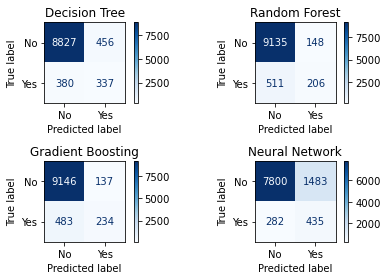

Decision Tree Confusion Matrix:
            Predicted No  Predicted Yes
Actual No           8827            456
Actual Yes           380            337

--------------------------------------------------

Random Forest Confusion Matrix:
            Predicted No  Predicted Yes
Actual No           9135            148
Actual Yes           511            206

--------------------------------------------------

Gradient Boosting Confusion Matrix:
            Predicted No  Predicted Yes
Actual No           9146            137
Actual Yes           483            234

--------------------------------------------------

Neural Network Confusion Matrix:
            Predicted No  Predicted Yes
Actual No           7800           1483
Actual Yes           282            435

--------------------------------------------------



In [40]:
for i, (name, clf) in enumerate(classifiers.items(), 1):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])  # Specify class labels
    plt.subplot(2, 2, i)
    disp.plot(ax=plt.gca(), cmap='Blues')
    plt.title(name)

plt.tight_layout()
plt.show()

for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, columns=["Predicted No", "Predicted Yes"], index=["Actual No", "Actual Yes"])
    print(f"{name} Confusion Matrix:")
    print(df_cm)
    print("\n" + "-"*50 + "\n")


Lets now check the ROC curve for all the models 

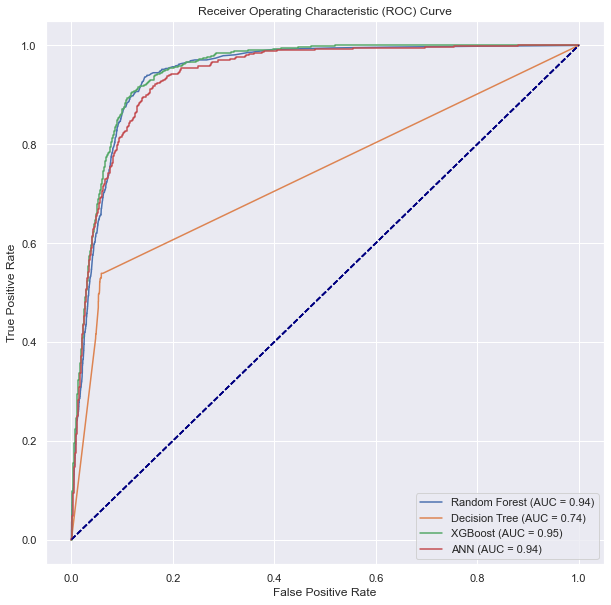

In [28]:
# Using the function for multiple classifiers
plot_individual_roc_curve("Random Forest", fpr_rfc, tpr_rfc)
plot_individual_roc_curve("Decision Tree", fpr_dt, tpr_dt)
plot_individual_roc_curve("XGBoost", fpr_xgb, tpr_xgb)
plot_individual_roc_curve("ANN", fpr_ann, tpr_ann, add_legend=True)
plt.show()